# 1. 绪论

In [1]:
# preparation
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline


from prml.preprocess import PolynomialFeature
from prml.linear import (
    LinearRegression,
    RidgeRegression,
    BayesianRegression
)

np.random.seed(1234)

## 1.1. Example: Polynomial Curve Fitting

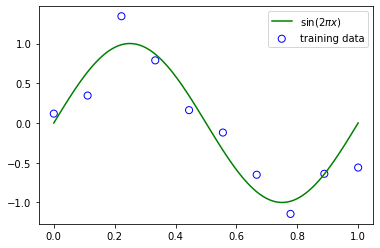

In [4]:
# sample data
def create_toy_data(func, sample_size, std):
    x = np.linspace(0, 1, sample_size)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

def func(x):
    return np.sin(2 * np.pi * x)

x_train, y_train = create_toy_data(func, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = func(x_test)

plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
plt.legend()
plt.show()

多项式拟合：<p>
    $y(x,w)=w_0+w_1x+w_2x^2+...+w_Mx^M=\sum_{j=0}^M {w_jx^j} \tag{1.1}$ 

误差函数<p>
$E(\boldsymbol{w})=\frac{1}{2} \sum_{n=1}^{N}\left\{y\left(x_{n}, \boldsymbol{w}\right)-t_{n}\right\}^{2} \tag{1.2}$<p>
目标是让误差函数越来越小。有唯一解$w^*$,是的$E(w)$取得最小值$E(w^*)$。

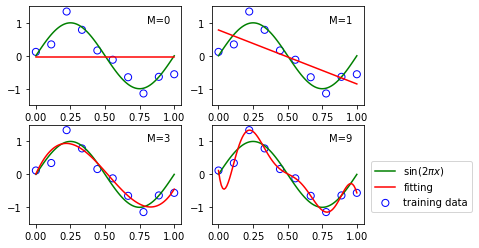

In [17]:
# 几个多项式拟合
for i, degree in enumerate([0, 1, 3, 9]):
    plt.subplot(2, 2, i + 1)
    feature = PolynomialFeature(degree)
    X_train = feature.transform(x_train)
    X_test = feature.transform(x_test)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y = model.predict(X_test)

    plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
    plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
    plt.plot(x_test, y, c="r", label="fitting")
    plt.ylim(-1.5, 1.5)
    plt.annotate("M={}".format(degree), xy=(0.8, 1))
plt.legend(bbox_to_anchor=(1.05, 0.64), loc=0, borderaxespad=0.)
plt.show()

m太大发生过拟合，泛化性能下降。需要一个衡量模型泛化能力的标准。

为了比较不同大小的数据集和保证和t有相同单位。引入均方根误差：<p>
    $E_{R M S}=\sqrt{2 E\left(\boldsymbol{w}^{*}\right) / N} \tag{1.3}$

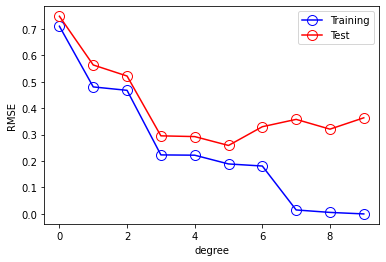

In [18]:
# 均方根对比
def rmse(a, b):
    return np.sqrt(np.mean(np.square(a - b)))

training_errors = []
test_errors = []

for i in range(10):
    feature = PolynomialFeature(i)
    X_train = feature.transform(x_train)
    X_test = feature.transform(x_test)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y = model.predict(X_test)
    training_errors.append(rmse(model.predict(X_train), y_train))
    test_errors.append(rmse(model.predict(X_test), y_test + np.random.normal(scale=0.25, size=len(y_test))))

plt.plot(training_errors, 'o-', mfc="none", mec="b", ms=10, c="b", label="Training")
plt.plot(test_errors, 'o-', mfc="none", mec="r", ms=10, c="r", label="Test")
plt.legend()
plt.xlabel("degree")
plt.ylabel("RMSE")
plt.show()

解决过拟合的方式：<p>
1. 增加样本个数<p>

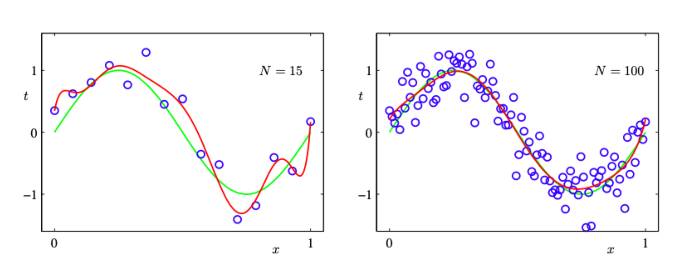

In [17]:
# 样本个数影响
fig, ax = plt.subplots(figsize=(12, 12))
d = plt.imread('./graph/1.1数据增加.png')
plt.axis('off')
ax.imshow(d)

2. 正则化
$\tilde{E}(\boldsymbol{w})=\frac{1}{2} \sum_{n=1}^{N}\left\{y\left(x_{n}, \boldsymbol{w}\right)-t_{n}\right\}^{2}+\frac{\lambda}{2}\|\boldsymbol{w}\|^{2} \tag{1.4}$
$\|\boldsymbol{w}\|^{2}\equiv=\boldsymbol{w}_0^2+\boldsymbol{w}_1^2+...+\boldsymbol{w}_M^2$，$\lambda$的大小控制的正则化影响的大小

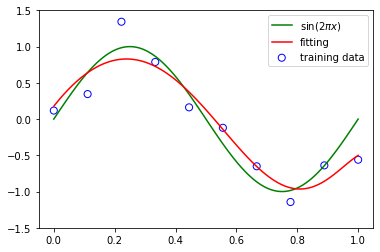

In [10]:
# M=9但用了正则化
feature = PolynomialFeature(9)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

model = RidgeRegression(alpha=1e-3)
model.fit(X_train, y_train)
y = model.predict(X_test)

y = model.predict(X_test)
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
plt.plot(x_test, y, c="r", label="fitting")
plt.ylim(-1.5, 1.5)
plt.legend()
plt.annotate("M=9", xy=(-0.15, 1))
plt.show()

# 1.2 概率论

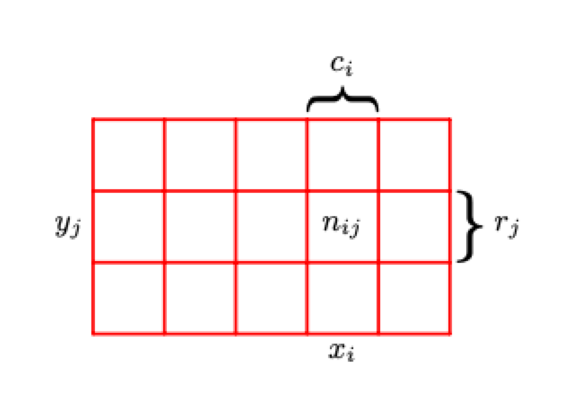

In [20]:
# 样本空间
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.2空间.png')
plt.axis('off')
ax.imshow(d)

这里有两个随机变量，X和Y.（离散变量，相互独立）图中简化为{$x_1,x_2,x_3,x_4,x_5$}和{$y_1,y_2,y_3$}。N次取样，每次得到一组的x,y。$X=x_{i}, Y=y_{i}$的取到次数是$n_{ij}$。于是我们有

$p\left(X=x_{i}, Y=y_{i}\right)=\frac{n_{i j}}{N} \tag{1.5}$ <p>
$p\left(X=x_{i}\right)=\frac{c_{i}}{N} \tag{1.6}$<p>

我们可以得到：<p>
$p\left(X=x_{i}\right)=\sum_{j=1}^{L}p\left(X=x_{i}, Y=y_{i}\right) \tag{1.7}$
这就是加法规则。$p\left(X=x_{i}\right)$被叫做边缘概率：因为它通过把其他变量(本例中的Y )边缘化或者加和得到。

条件概率：<p>
$p\left(Y=y_{j} | X=x_{i}\right)=\frac{n_{i j}}{c_i} \tag{1.8}$
    

$p\left(X=x_{i}, Y=y_{j}\right)=\frac{n_{i j}}{N}=\frac{n_{i j}}{c_{i}} \cdot \frac{c_{i}}{N}=p\left(Y=y_{j} | X=x_{i}\right) p\left(X=x_{i}\right) \tag{1.9}$
这就是乘积规则。

sum rule $p(X)=\sum_{Y}p(X,Y) \tag{1.10}$ <p>
product rule $p(X,Y)=P(Y|X)p(X) \tag{1.11}$

根据这两个式子得到本书最重要的定义：贝叶斯定理。<p>
$P(Y | X)=\frac{P(X | Y) P(Y)}{P(X)} \tag{1.12}$

分子中的$P(x)=\sum_{Y}P\left(X | Y\right)P\left(Y\right)$其实这就是加法规则。也确保了概率在归一化之后的值为1.

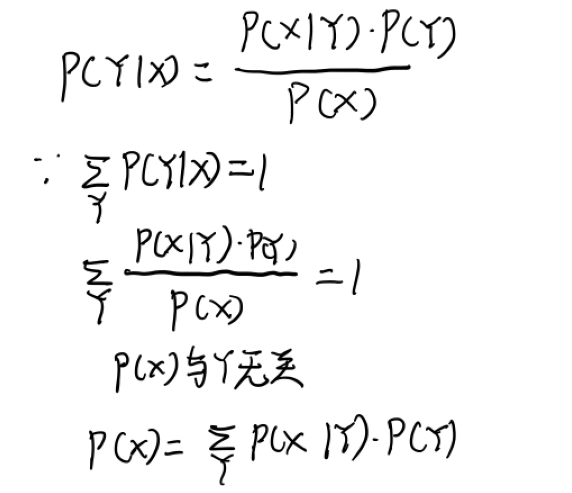

In [19]:
# 样本个数影响
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.2归一化.png')
plt.axis('off')
ax.imshow(d)

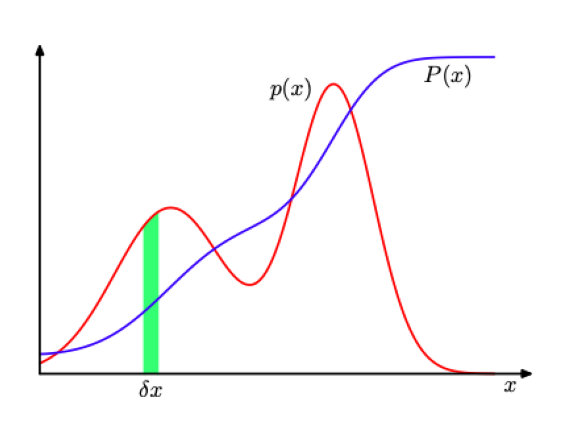

In [23]:
# 累计密度分布
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.2累计概率.png')
plt.axis('off')
ax.imshow(d)

## 积分就是连续情况下的相加

1.2.1 概率密度<p>    
如果一个实值变量$x$落在区间$(x, x + \delta x)$的概率由$p(x)\delta x$给出，其中$ \delta x \to 0 $，那么我们就把$ p(x) $称作$ x $的概率密度（probability density）。<p>
连续概率分布：<p>
    $p(x \in(a, b))=\int_{a}^{b} p(x) \mathrm{d}x \tag{1.24}$<p>

满足：<p>
    $p(x)\geq0 \tag{1.25}$ <p>
    $\int_{-\infty}^{\infty} p(x) \mathrm{d}x=1 \tag{1.26}$

可以用过Jacobian因子变化：例如:$x=g(y)$<p>
    $p_{y}(y)=p_{x}(x)\left|\frac{\mathrm{d} x}{\mathrm{d} y}\right|=p_{x}(g(y))\left|g^{\prime}(y)\right| \tag{1.27}$ <p>
    概率密度最大值的概念取决于变量的选择

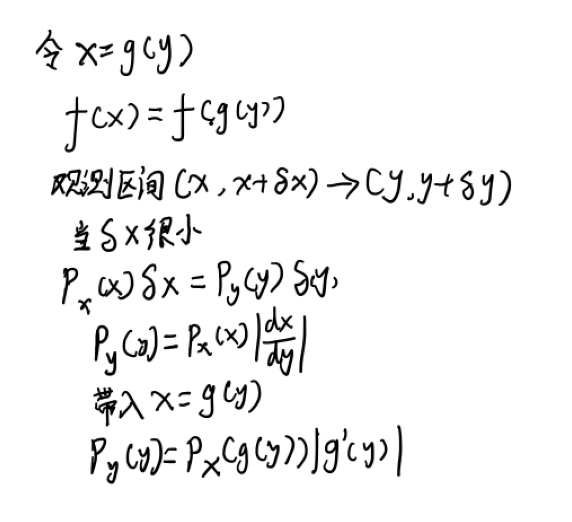

In [21]:
# 概率形式变换
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/1.2形式变化.png')
plt.axis('off')
ax.imshow(d)

定义累计密度分布：<p>
    $$ P(z) = \int_{-\infty}^z p(x)dx \tag{1.28} $$<p>
满足$$ P^\prime(x) = p(x) $$
多变量的时候x是向量，定义是相似的。

加法法则和乘法法则<p>
$p(x) = \int p(x, y) dy \tag{1.31}$ <p>
$p(x, y)= p(y|x)p(x) \tag{1.32}$

1.2.2 期望和方差